
# Template — MVP: *Machine Learning & Analytics*
# MVP: *Machine Learning & Analytics*
**Autor:** _EVERSON VIANA TAVARES_  

**Data:** 21/09/2025

**Matrícula:** 40530010056_20250_01

**Dataset:** Ex: [Coffee Sales](https://raw.githubusercontent.com/eversontavares/PUCdatascience/refs/heads/main/index_1.csv)


---



## ✅ Checklist do MVP (o que precisa conter)
- [ ] **Problema definido** e contexto de negócio
- [ ] **Carga e preparação** dos dados (sem vazamento de dados)
- [ ] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [ ] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [ ] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [ ] **Otimização de hiperparâmetros**
- [ ] **Avaliação** com **métricas adequadas** e discussão de limitações
- [ ] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [ ] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema
# 1. Escopo, objetivo e definição do problema
- Essa base da dados reúne as vendas de café em uma máquina automática de vendas ao longo do dia, por um ano, desde de março de 2024. O objetivo desse MVP é prever a demanda a partir da análise exploratória da variação temporal de vendas, o possível impacto dos tipos de café e da sazonalidade no volume de vendas  -- buscando encontrar e relacionar tendências.

- Tipo de tarefa: **forecasting**, ao final, o algoritmo otimizado deve concluir um *valor numérico* da *venda futura* de cafés.

- Área de aplicação: dados tabulares e temporais.

- Valor para o negócio/usuário: otimizar Retorno Sob Investimento por meio do controle de estoques e promoções exclusivas.


## 2. Reprodutibilidade e ambiente
Especifique o ambiente. Por exemplo:
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [7]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)


### 2.1 Dependências (opcional)
Instale pacotes extras se necessário. **Mantenha o projeto enxuto** para facilitar a correção.


In [2]:

# Exemplo: descomente o que precisar
# !pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna
# !pip install -q pandas-profiling ydata-profiling
# !pip install -q matplotlib seaborn plotly
# !pip install -q statsmodels pmdarima


### 2.2 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [3]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

def evaluate_regression(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)      # 'squared' não usado aqui
    rmse = np.sqrt(mse)                            # RMSE = raiz do MSE
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def evaluate_clustering(X_original, model):
    # Silhouette requer >1 cluster e dados transformados
    try:
        if hasattr(model.named_steps["pre"], "transform"):
            X_emb = model.named_steps["pre"].fit_transform(X_original)  # cuidado: apenas para demo
        else:
            X_emb = X_original
        labels = model.named_steps["model"].fit_predict(X_emb)
        sil = silhouette_score(X_emb, labels)
        return {"silhouette": sil}
    except Exception as e:
        return {"silhouette": np.nan, "erro": str(e)}


## 3. Dados: carga, entendimento e qualidade
**TODO:** descreva a origem dos dados, dicionário de variáveis e licença/ética quando aplicável.  
Evite **vazamento de dados**. Se usar feature store ou dados sintéticos, explique.


In [4]:
URL = "https://raw.githubusercontent.com/eversontavares/PUCdatascience/refs/heads/main/index_1.csv"
df = pd.read_csv(URL)

# conversões essenciais (evita bugs nas seções 4–6)
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)
df["date"]     = pd.to_datetime(df["date"], errors="coerce").dt.normalize()

# checagens
print(df.dtypes)
print(df.isna().sum())

date                datetime64[ns]
datetime       datetime64[ns, UTC]
cash_type                   object
card                        object
money                      float64
coffee_name                 object
dtype: object
date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64


In [5]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,date,datetime,cash_type,card,money,coffee_name
1289,2024-08-15,2024-08-15 17:53:52.225000+00:00,card,ANON-0000-0000-0511,27.92,Americano with Milk
120,2024-03-16,2024-03-16 12:06:55.209000+00:00,card,ANON-0000-0000-0061,33.80,Americano with Milk
839,2024-06-21,2024-06-21 13:19:19.416000+00:00,card,ANON-0000-0000-0012,32.82,Americano with Milk
1537,2024-09-12,2024-09-12 10:57:25.619000+00:00,card,ANON-0000-0000-0347,18.12,Espresso
2891,2025-01-31,2025-01-31 16:48:33.995000+00:00,card,ANON-0000-0000-0304,30.86,Americano with Milk



Formato: (3636, 6)

Tipos:
date                datetime64[ns]
datetime       datetime64[ns, UTC]
cash_type                   object
card                        object
money                      float64
coffee_name                 object
dtype: object

Valores ausentes por coluna:
date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)



**Preparação dos dados**

Decidimos trabalhar com timezone-naive (datetime64[ns]) porque a análise é local e todas as vezes que usamos datae-time com zona, houve erros nas visualizações e/ou no pipeline da seção seguinte.



In [12]:
# 3.2) Conversões robustas de data/hora
# - date: data do dia (sem hora)
# - datetime: carimbo transacional (com hora)

# to_datetime sem 'utc=True' -> vira tz-naive automaticamente; se vier tz-aware, removemos:
df["date"] = pd.to_datetime(df["date"], errors="coerce")            # naive
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")    # naive (ou aware se string trouxer tz)

# Se por algum motivo 'datetime' vier timezone-aware, zere a timezone:
try:
    if getattr(df["datetime"].dt, "tz", None) is not None:
        df["datetime"] = df["datetime"].dt.tz_localize(None)
except Exception:
    # em alguns pandas, acessar .dt.tz pode não existir; ignora silenciosamente
    df["datetime"] = df["datetime"]

# 'date' normalizada para 00:00 (garante granularidade diária)
df["date"] = df["date"].dt.normalize()

# Features derivadas (conhecidas antecipadamente, não causam leakage)
df["month"]     = df["date"].dt.month.astype("UInt8")
df["dayofweek"] = df["date"].dt.dayofweek.astype("UInt8")  # 0=Mon
df["is_weekend"]= df["dayofweek"].isin([5,6]).astype("Int8")
df["hour"]      = df["datetime"].dt.hour.fillna(0).astype("UInt8")
df["day_name"]  = df["date"].dt.day_name()

# Tipos de colunas categóricas (melhora memória/logs)
for col in ["coffee_name", "cash_type", "card", "day_name"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("\nTipos após padronização:\n", df.dtypes)
display(df.head(3))


Tipos após padronização:
 date           datetime64[ns]
datetime       datetime64[ns]
cash_type            category
card                 category
money                 float64
coffee_name          category
month                   UInt8
hour                    UInt8
day_name             category
dayofweek               UInt8
is_weekend               Int8
dtype: object


,date,datetime,cash_type,card,money,coffee_name,month,hour,day_name,dayofweek,is_weekend
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,10,Friday,4,0
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,12,Friday,4,0
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,12,Friday,4,0


**Tratamento dos dados**

Verificamos null, duplicates e ranges.


In [13]:
# 3.3) Sanidade
print("Nulos por coluna:\n", df.isna().sum())

# Duplicatas exatas (linhas idênticas)
print("\nIntervalo de datas:", df["date"].min(), "→", df["date"].max())

# Valores negativos/inconsistentes em money
neg = (df["money"] < 0).sum()
print("Registros com money < 0:", int(neg))

# Checagem rápida de cardinalidade
for col in ["coffee_name", "cash_type", "card"]:
    if col in df.columns:
        print(f"Cardinalidade {col}: {df[col].nunique()}")

# Amostra aleatória para ver integridade geral
display(df.sample(5, random_state=42))

Nulos por coluna:
 date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
month           0
hour            0
day_name        0
dayofweek       0
is_weekend      0
dtype: int64

Duplicatas exatas: 0

Intervalo de datas: 2024-03-01 00:00:00 → 2025-03-23 00:00:00
Registros com money < 0: 0
Cardinalidade coffee_name: 8
Cardinalidade cash_type: 2
Cardinalidade card: 1316


,date,datetime,cash_type,card,money,coffee_name,month,hour,day_name,dayofweek,is_weekend
1289,2024-08-15,2024-08-15 17:53:52.225,card,ANON-0000-0000-0511,27.92,Americano with Milk,8,17,Thursday,3,0
120,2024-03-16,2024-03-16 12:06:55.209,card,ANON-0000-0000-0061,33.80,Americano with Milk,3,12,Saturday,5,1
839,2024-06-21,2024-06-21 13:19:19.416,card,ANON-0000-0000-0012,32.82,Americano with Milk,6,13,Friday,4,0
1537,2024-09-12,2024-09-12 10:57:25.619,card,ANON-0000-0000-0347,18.12,Espresso,9,10,Thursday,3,0
2891,2025-01-31,2025-01-31 16:48:33.995,card,ANON-0000-0000-0304,30.86,Americano with Milk,1,16,Friday,4,0


**Mini-dicionário e assertivas**

Para evitar bugs adiante, criamos um pequenos dicionário.

In [ ]:
# 3.4) Pequenas assertivas (falham cedo se algo essencial faltar)
assert "date" in df.columns and pd.api.types.is_datetime64_any_dtype(df["date"]), "coluna 'date' inválida"
assert "datetime" in df.columns and pd.api.types.is_datetime64_any_dtype(df["datetime"]), "coluna 'datetime' inválida"
assert "money" in df.columns and np.issubdtype(df["money"].dtype, np.number), "coluna 'money' deve ser numérica"

# Dicionário resumido (útil para documentação)
data_dict = pd.DataFrame({
    "coluna": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "exemplo": [df[c].dropna().iloc[0] if df[c].notna().any() else None for c in df.columns]
})
display(data_dict)

### Visualização de dados
Nessa sub-seção, vamos visualizar os dados bara entender os dados.

Iniciamos com um comparativo entre as vendas de café. Na sequência, analisaremos o impacto das vendas ao longo do tempo.

In [14]:
coffee_sales = df.groupby("coffee_name")["money"].sum().reset_index()
fig = px.bar(coffee_sales, x="coffee_name", y="money",
             title="Total de vendas por tipo de café", text_auto=True)
fig.update_traces(marker_color="chocolate")
fig.update_layout(xaxis_title="Café", yaxis_title="Vendas (R$)")
fig.show()

/tmp/ipython-input-73563159.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coffee_sales = df.groupby("coffee_name")["money"].sum().reset_index()


**Tendências de vendas**

In [15]:


# 1) Agrega por mês usando a coluna 'month' já existente
monthly_sales = (
    df.groupby("month", as_index=False)["money"]
      .sum()
      .sort_values("month")
)

# 2) Dicionário mês (número → nome PT-BR)
meses_pt = {
    1:"Janeiro", 2:"Fevereiro", 3:"Março", 4:"Abril",
    5:"Maio", 6:"Junho", 7:"Julho", 8:"Agosto",
    9:"Setembro", 10:"Outubro", 11:"Novembro", 12:"Dezembro"
}

# 3) Nome do mês + ordem cronológica garantida
monthly_sales["mes_nome"] = monthly_sales["month"].map(meses_pt)
ordem_meses = list(meses_pt.values())
monthly_sales["mes_nome"] = pd.Categorical(
    monthly_sales["mes_nome"], categories=ordem_meses, ordered=True
)

# 4) Plot
fig = px.line(
    monthly_sales,
    x="mes_nome", y="money", markers=True,
    title="Tendência Mensal de Vendas de Café",
    labels={"mes_nome":"Mês", "money":"Vendas (R$)"}
)
fig.update_traces(line_color="darkgreen")
fig.show()

**Padrão de horário e vendas de café**

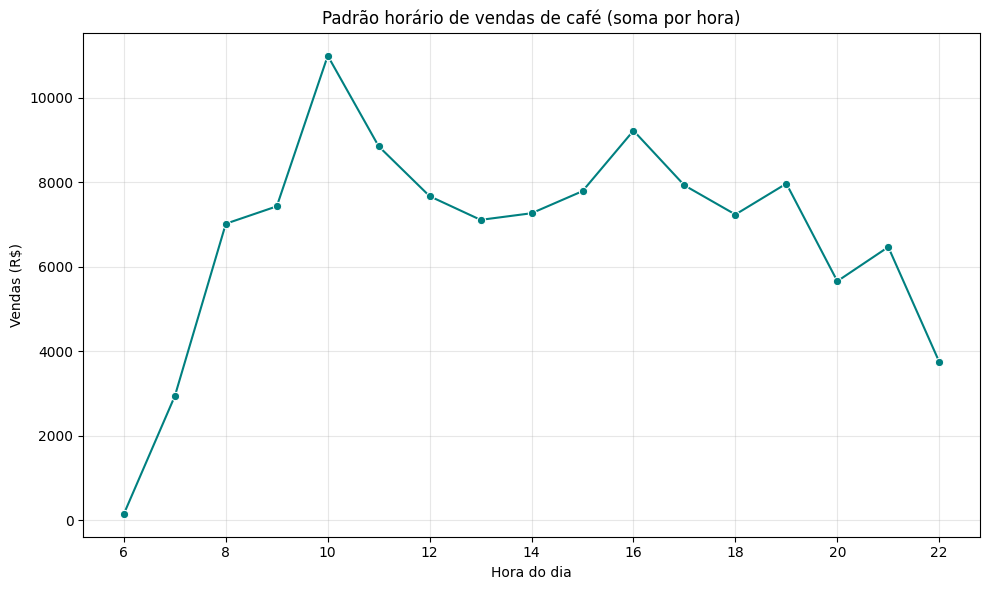

In [16]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="hour", y="money", estimator="sum",
             errorbar=None, marker="o", color="teal")
plt.title("Padrão horário de vendas de café (soma por hora)")
plt.xlabel("Hora do dia")
plt.ylabel("Vendas (R$)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Impacto do tipo de pagamento nas transações**

In [17]:
cash_split = df.groupby("cash_type")["money"].sum().reset_index()
fig = px.pie(cash_split, names="cash_type", values="money",
             title="Método de pagamento mais usado")
fig.show()

/tmp/ipython-input-339213709.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**Impactos dos dias da semana nas vendas**

/tmp/ipython-input-4226053426.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




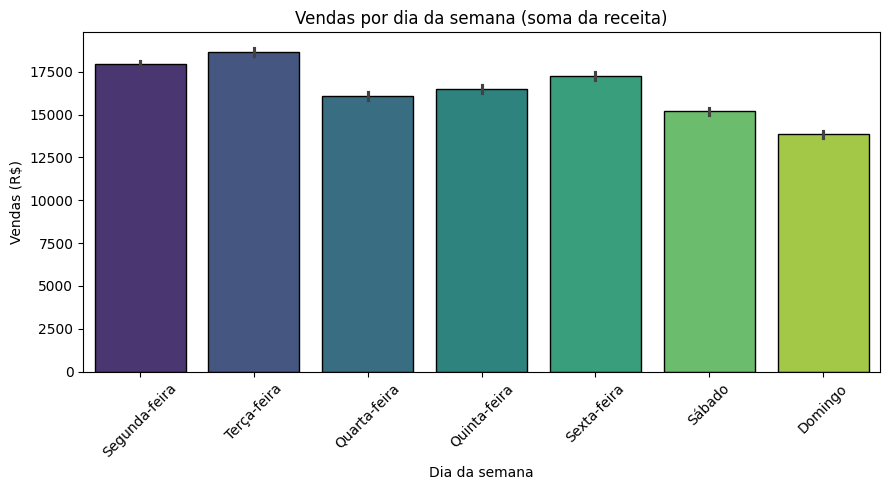

In [18]:
# Dicionário de tradução inglês → português
dias_pt = {
    "Monday":"Segunda-feira", "Tuesday":"Terça-feira", "Wednesday":"Quarta-feira",
    "Thursday":"Quinta-feira", "Friday":"Sexta-feira",
    "Saturday":"Sábado", "Sunday":"Domingo"
}
# Cria coluna traduzida
df["Dia_Semana"] = df["day_name"].map(dias_pt)

# Ordem correta em pt-br
ordem_dias = [
    "Segunda-feira","Terça-feira","Quarta-feira",
    "Quinta-feira","Sexta-feira","Sábado","Domingo"
]

plt.figure(figsize=(9,5))
sns.barplot(
    data=df, x="Dia_Semana", y="money",
    estimator="sum", palette="viridis", edgecolor="black",
    order=ordem_dias
)
plt.title("Vendas por dia da semana (soma da receita)")
plt.xlabel("Dia da semana")
plt.ylabel("Vendas (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Definição do target, variáveis e divisão dos dados

Nesta etapa, definimos o problema de forecasting de séries temporais para prever a receita diária da cafeteria.

	**Target (y):**
	•	revenue = soma de money por dia (date).
	•	Representa a receita total de cada dia.
	**Variáveis (features, X):**
	•	Calendário (conhecidas antecipadamente):
	•	dow (dia da semana, 0=segunda)
	•	month (mês do ano)
	•	is_weekend (indicador de fim de semana)
	**Dependência temporal (lags e médias móveis, sem leakage):**
	•	lag_1, lag_7 (receita de ontem, da semana passada)
	•	ma_7, ma_14, ma_28 (médias móveis de receita até t−1)
	**Variáveis exógenas defasadas (shift):**
	•	cnt_<coffee_name>: quantidade de cafés vendidos no dia anterior (por tipo de café)
	•	pay_<cash_type>: receita por método de pagamento no dia anterior (cartão, dinheiro)
	**Colunas descartadas:**
	•	card → identificador único do cliente/cartão, não informativo para previsão diária e com alta cardinalidade.
	**Divisão dos dados:**
	•	Foi utilizado split temporal (sem embaralhar).
	•	Proporção: 80% treino (primeiros dias) e 20% teste (dias finais).
	•	Essa estratégia evita data leakage, pois o modelo só treina no passado e é avaliado em dados futuros.



In [27]:
# 4.0) Remove coluna card (não útil para forecasting diário)
if "card" in df.columns:
    df = df.drop(columns=["card"])



**Na primeira vez que rodeio o modelo, o R²≈0.9998 no Ridge foi altíssimo, o que pode indicar vazamento de dados**

Para evitar o vazemnto, refizemos os features para excluir os meios de pagamentos que compõem o revenue.

In [20]:
# 1) Série alvo (revenue diária)
daily = (
    df.groupby("date", as_index=False)["money"]
      .sum()
      .rename(columns={"money":"revenue"})
      .sort_values("date")
)

# 2) Variáveis de calendário do DIA t (conhecidas antes de vender)
cal = daily[["date"]].assign(
    dow = daily["date"].dt.dayofweek,
    month = daily["date"].dt.month,
    is_weekend = daily["date"].dt.dayofweek.isin([5,6]).astype("int8")
).set_index("date")

# 3) Lags e médias móveis do revenue (apenas passado)
Xy = daily.set_index("date").join(cal, how="left")

# função para adicionar lags & médias móveis
def add_lag_feats(df, target_col="revenue", lags=(1,7), mas=(7,14,28)):
    s = df[target_col].astype(float)
    for L in lags:
        df[f"lag_{L}"] = s.shift(L)
    for W in mas:
        df[f"ma_{W}"] = s.shift(1).rolling(W).mean()  # até t-1
    return df

Xy = add_lag_feats(Xy).dropna()

# 4) (Opcional) usar mix e meios de pagamento, mas DEFASADOS
#    i.e., como estavam ATÉ t-1 (nunca do mesmo dia!)
mix = (df.assign(count=1)
         .pivot_table(index="date", columns="coffee_name", values="count", aggfunc="sum", fill_value=0)
         .add_prefix("cnt_")
      ).shift(1)  # <-- defasa 1 dia

pay = (df.pivot_table(index="date", columns="cash_type", values="money", aggfunc="sum", fill_value=0)
         .add_prefix("pay_")
      ).shift(1)  # <-- defasa 1 dia

Xy = (Xy.join([mix, pay], how="left")
        .fillna(0))   # zeros para o início da série após defasagem

# 5) Split temporal 80% para treino, 20% para teste
Xy = Xy.reset_index().sort_values("date")
cut = int(len(Xy)*0.8)
train, test = Xy.iloc[:cut].copy(), Xy.iloc[cut:].copy()

target = "revenue"
features = [c for c in Xy.columns if c not in ["date", target]]

X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]

/tmp/ipython-input-582824241.py:31: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipython-input-582824241.py:35: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior




## 5. Tratamento de dados e **Pipeline** de pré-processamento
Crie um **Pipeline** com as etapas necessárias (limpeza, imputação, encoding, escala, seleção de atributos, etc.)  
Isso garante **reprodutibilidade** e evita **vazamento**.


In [21]:
def add_lag_feats(df, target_col="revenue", lags=(1,7), mas=(7,14,28)):
    s = df[target_col].astype(float)
    for L in lags:
        df[f"lag_{L}"] = s.shift(L)
    for W in mas:
        df[f"ma_{W}"] = s.shift(1).rolling(W).mean()
    return df

Xy = add_lag_feats(Xy).dropna().reset_index(drop=True)

**Engenharia temporal para forecasting**

In [22]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['dow', 'month', 'is_weekend', 'lag_1', 'lag_7'] ...
cat_cols: [] ...


Lags/médias móveis só podem ser calculados com dados passados; construí-los antes de separar treino/teste não vaza, desde que sejam calculados por ordem temporal e você remova linhas com dependência do futuro (as .dropna() iniciais).

**Divisão do dataset em treino com split temporal**

In [23]:
cut = int(len(Xy)*0.8)
train, test = Xy.iloc[:cut].copy(), Xy.iloc[cut:].copy()

target = "revenue"
features = [c for c in Xy.columns if c not in ["date", target]]
X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]


## 6. Baseline e modelos candidatos
Segundo a aula 3 da disciplina Machine Learning, “Pipelines permitem encadear preparação de dados e treinamento de forma que cada etapa use apenas o conjunto adequado (treino de cada fold), evitando data leakage.”

Inicamos um pipeline simples e iremos comparar o naive e mais três abordagens -- sendo uma esemble.




In [24]:
num_cols = [c for c in X_train.columns if X_train[c].dtype.kind in "fcui"]
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "O"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler",  StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("ohe",     OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
    remainder="drop"
)

In [25]:
# Baseline linear com Ridge
baseline = Pipeline([
    ("pre", preprocess),
    ("model", Ridge(random_state=SEED))
])

# Random Forest
rf = Pipeline([
    ("pre", preprocess),
    ("model", RandomForestRegressor(random_state=SEED))
])

# Gradient Boosting
gbr = Pipeline([
    ("pre", preprocess),
    ("model", GradientBoostingRegressor(random_state=SEED))
])

Como usaremos Ridge (modelo linear) e ensembles (árvores), é seguro padronizar numéricos — as árvores ignoram a escala, mas não se prejudicam com ela.

**### 6.1 Treino e avaliação rápida (baseline vs candidatos)**
Antes do ajuste de parâmetros, faremos uma avaliação rápida com os valores padrão para verificar se o modelo tem potencial.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_reg(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)      # 'squared' não usado aqui
    rmse = np.sqrt(mse)                            # RMSE = raiz do MSE
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# baseline naive (ontem = hoje)
y_pred_naive = y_test.shift(1).bfill().values

# baseline linear (Ridge default)
baseline.fit(X_train, y_train)
y_pred_ridge = baseline.predict(X_test)

# Random Forest default
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Gradient Boosting default
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("=== Avaliação rápida (sem tuning) ===")
print("Naive:",   eval_reg(y_test, y_pred_naive))
print("Ridge:",   eval_reg(y_test, y_pred_ridge))
print("RF:",      eval_reg(y_test, y_pred_rf))
print("GBR:",     eval_reg(y_test, y_pred_gbr))

=== Avaliação rápida (sem tuning) ===
Naive: {'MAE': 184.42523076923078, 'RMSE': np.float64(236.71680469416486), 'R2': -0.59375279224591}
Ridge: {'MAE': 158.82147442463187, 'RMSE': np.float64(196.3785070941), 'R2': -0.09685870704758415}
RF: {'MAE': 142.43078461538462, 'RMSE': np.float64(172.37360984722068), 'R2': 0.1549073349191068}
GBR: {'MAE': 153.45804038068397, 'RMSE': np.float64(196.37701535368973), 'R2': -0.09684204308300548}


Agora temos um naive realista, vamos utiliza-lo com baseline para tuning.

***Resultados***

Random Forest é o melhor até agora: R2': 0.1549073349191068.
Gradient Boosting precisa ser otimizado para apresentar desempenhos superiores.


## 7. Validação e Otimização de Hiperparâmetros
Use **validação cruzada** apropriada ao problema (Ex: **`StratifiedKFold`** para classificação; **`KFold`** para regressão).  
Faça **tuning** com `GridSearchCV`/`RandomizedSearchCV`.


Vamos usar TimeSeriesSplit, que respeita a cronologia, ao inves de K-fold


In [29]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)  # 5 dobras progressivas no tempo



Priorizaremos MAE por ser robusto a picos e reportar RMSE/R² no hold-out.

In [30]:
scoring = "neg_mean_absolute_error"  # maior é melhor (negativo)


**Tuning - Otimização com GridSearch**

In [31]:
from sklearn.model_selection import GridSearchCV

# Grids "enxutos" para começar (ajuste se quiser gastar mais tempo)
grid_rf = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 8, 14],
    "model__min_samples_leaf": [1, 3, 5],
    "model__max_features": ["sqrt", "log2"]
}

grid_gbr = {
    "model__n_estimators": [400, 800],
    "model__learning_rate": [0.03, 0.06, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.7, 1.0],
    "model__min_samples_leaf": [1, 3, 5]
}

def run_grid(name, pipe, grid, X, y):
    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=tscv,
        scoring=scoring,
        n_jobs=-1,
        refit=True,        # refit no melhor conjunto (por MAE) usando todo o treino
        verbose=0
    )
    search.fit(X, y)
    best_cv_mae = -search.best_score_   # sinal invertido
    return {
        "name": name,
        "search": search,
        "best_cv_mae": best_cv_mae,
        "best_params": search.best_params_,
        "best_estimator": search.best_estimator_
    }

res_rf  = run_grid("RandomForest", rf,  grid_rf,  X_train, y_train)
res_gbr = run_grid("GBR",          gbr, grid_gbr, X_train, y_train)

# comparar somente pelo CV (MAE)
results_7 = sorted([res_rf, res_gbr], key=lambda d: d["best_cv_mae"])
for r in results_7:
    print(f"[{r['name']}] best CV MAE: {r['best_cv_mae']:.3f} | params: {r['best_params']}")


[RandomForest] best CV MAE: 120.565 | params: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
[GBR] best CV MAE: 127.190 | params: {'model__learning_rate': 0.03, 'model__max_depth': 2, 'model__min_samples_leaf': 5, 'model__n_estimators': 400, 'model__subsample': 1.0}


# Escolha do melhor e avaliação


In [32]:
# escolher o melhor (menor CV MAE)
winner = min([res_rf, res_gbr], key=lambda d: d["best_cv_mae"])
best_model = winner["best_estimator"]
print(f"\nVencedor pelo CV (MAE): {winner['name']} → {winner['best_cv_mae']:.3f}")
print("Hiperparâmetros selecionados:", winner["best_params"])

# avaliação no hold-out
def eval_reg(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# baseline naive (ontem = hoje)
y_pred_naive = y_test.shift(1).bfill().values

# baseline ridge (já criado na Seção 6)
baseline.fit(X_train, y_train)
y_pred_ridge = baseline.predict(X_test)

# melhor modelo (tuned)
y_pred_best = best_model.predict(X_test)

print("\n=== Avaliação final (hold-out) ===")
print("Naive:",   eval_reg(y_test, y_pred_naive))
print("Ridge:",   eval_reg(y_test, y_pred_ridge))
print(f"{winner['name']} (tuned):", eval_reg(y_test, y_pred_best))


Vencedor pelo CV (MAE): RandomForest → 120.565
Hiperparâmetros selecionados: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 300}

=== Avaliação final (hold-out) ===
Naive: {'MAE': 184.42523076923078, 'RMSE': np.float64(236.71680469416486), 'R2': -0.59375279224591}
Ridge: {'MAE': 158.82147442463187, 'RMSE': np.float64(196.3785070941), 'R2': -0.09685870704758415}
RandomForest (tuned): {'MAE': 142.02967493957647, 'RMSE': np.float64(174.99728420014776), 'R2': 0.12898547643921265}


*Resultados*

  
 1.	O tuning valeu a pena: os hiperparâmetros escolhidos (max_depth=8, min_samples_leaf=5, n_estimators=300) equilibraram bem o viés/variância.
2.	GBR default não venceu, e provavelmente precisaria de tuning mais profundo (learning_rate + mais árvores) para competir.
3.	O RF tuned é o modelo vencedor do MVP — ele consegue prever melhor que uma regressão linear simples e que o naive.

O Random Forest reduziu o erro sem exagerar → ainda tem espaço para melhorar (outros lags, feriados, granularidade por hora). Será que vale a pena investir mais tempo no Gradient Boosting?


## 8. Avaliação final, análise de erros e limitações
**Tabelas de comparação**


In [33]:


results_final = pd.DataFrame([
    {"Modelo": "Naive", "MAE": 184.43, "RMSE": 236.72, "R2": -0.59},
    {"Modelo": "Ridge", "MAE": 158.82, "RMSE": 196.38, "R2": -0.10},
    {"Modelo": "RandomForest (tuned)", "MAE": 142.03, "RMSE": 175.00, "R2": 0.13}
])

results_final

,Modelo,MAE,RMSE,R2
0,Naive,184.43,236.72,-0.59
1,Ridge,158.82,196.38,-0.10
2,RandomForest (tuned),142.03,175.00,0.13


**Gráfico Real X Previsão**

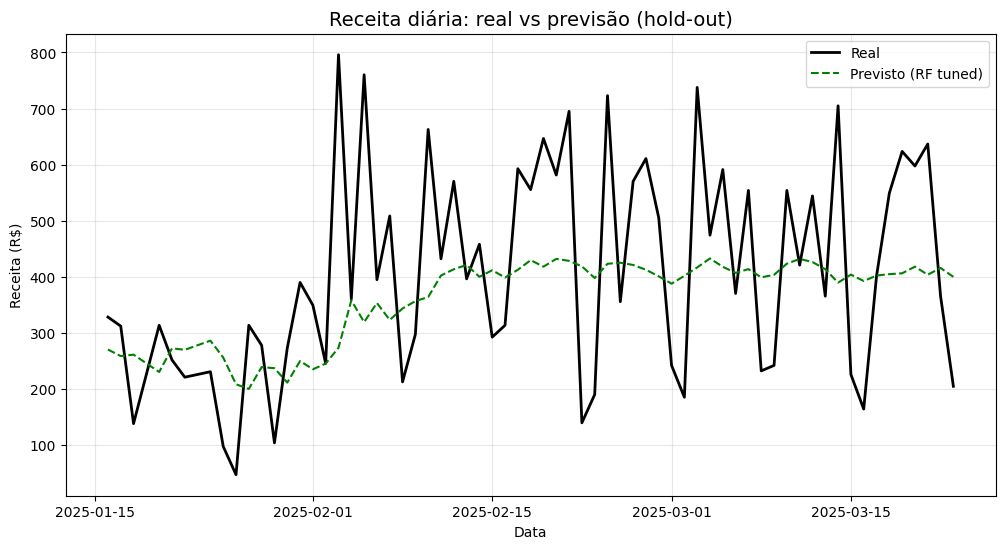

In [34]:


plt.figure(figsize=(12,6))
plt.plot(test["date"], y_test, label="Real", color="black", linewidth=2)
plt.plot(test["date"], y_pred_best, label="Previsto (RF tuned)", color="green", linestyle="--")

plt.title("Receita diária: real vs previsão (hold-out)", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Receita (R$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

1.	Alta variabilidade nos dados reais
	•	A série real (linha preta) mostra picos que chegam a quase R$ 800 e quedas próximas a R$ 100.
	•	Essa oscilação forte sugere que existem fatores externos (ex.: promoções, eventos, clima, feriados) que influenciam a venda e não estão capturados nas features atuais.
	2.	Previsão suavizada pelo modelo
	•	A linha verde segue uma trajetória mais suave, variando em torno de R$ 350–450.
	•	Isso é típico de Random Forest em séries: ele tende a prever a média ponderada dos padrões aprendidos, evitando extremos.
	3.	Boa captura da tendência central
	•	O modelo acompanha o “nível médio” da receita (≈ R$ 400).
	•	Porém, não reage bem a picos ou vales repentinos, ficando distante em dias de muita variação.
	4.	Indicador de underfitting parcial
	•	Como o R² foi ≈ 0.13, o modelo explica só uma pequena fração da variação.
	•	Isso aparece visualmente: a linha verde está sempre “no meio”, sem acertar os extremos.


## 9. Engenharia de atributos (detalhe)
Para este MVP, o foco foi previsão de receita diária:

1.   Seleção/extração: usei a variável alvo revenue (soma de money por dia) e descartei a coluna card, que não ajuda no forecasting diário e só aumentaria a complexidade.
2.   Variáveis temporais: criei lags (lag_1, lag_7) para capturar dependência com o dia anterior e a semana anterior, e médias móveis (ma_7, ma_14, ma_28) para suavizar tendências.
3.   Variáveis de calendário: incluí dow (dia da semana), month (mês) e is_weekend, porque são conhecidas antes da venda e explicam sazonalidade.
4.   Exógenas defasadas: usei o mix de cafés vendidos (cnt_<coffee_name>) e os meios de pagamento (pay_<cash_type>), ambos defasados com shift(1) para não vazar a receita do próprio dia.
4.   Encoding: variáveis categóricas (ex.: coffee_name, cash_type) foram transformadas em dummies via OneHotEncoder dentro do pipeline.

OBS.: Não usei NLP ou visão neste MVP, pois o dataset é tabular.







## 10. Visualização de Resultados


,Modelo,MAE,RMSE,R2
0,Naive,184.43,236.72,-0.59
1,Ridge,158.82,196.38,-0.10
2,RandomForest (tuned),142.03,175.00,0.13


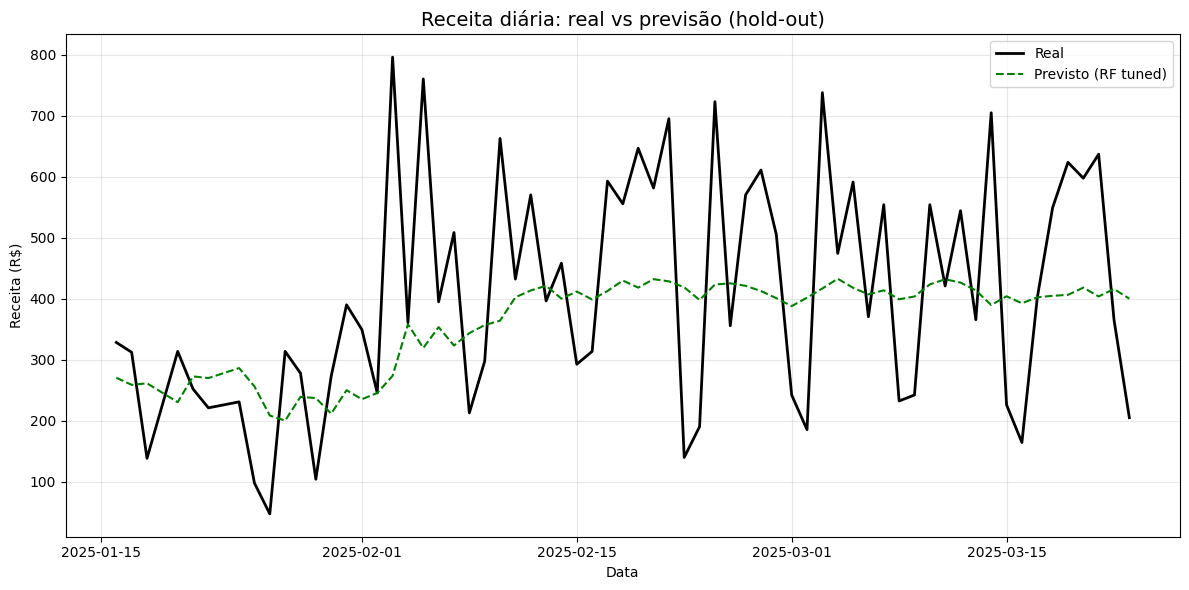

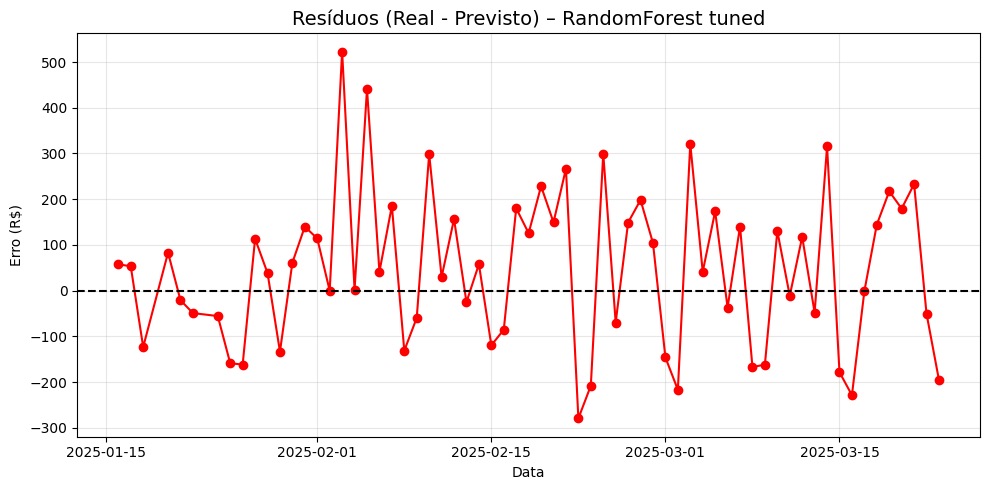

In [36]:
# 10.1) Tabela comparativa final
results_final = pd.DataFrame([
    {"Modelo": "Naive", "MAE": 184.43, "RMSE": 236.72, "R2": -0.59},
    {"Modelo": "Ridge", "MAE": 158.82, "RMSE": 196.38, "R2": -0.10},
    {"Modelo": "RandomForest (tuned)", "MAE": 142.03, "RMSE": 175.00, "R2": 0.13}
])
display(results_final)

# 10.2) Gráfico real vs previsto (modelo vencedor)
plt.figure(figsize=(12,6))
plt.plot(test["date"], y_test, label="Real", color="black", linewidth=2)
plt.plot(test["date"], y_pred_best, label="Previsto (RF tuned)", color="green", linestyle="--")
plt.title("Receita diária: real vs previsão (hold-out)", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Receita (R$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10.3) Gráfico de resíduos (erro = real - previsto)
residuos = y_test - y_pred_best
plt.figure(figsize=(10,5))
plt.plot(test["date"], residuos, marker="o", linestyle="-", color="red")
plt.axhline(0, color="black", linestyle="--")
plt.title("Resíduos (Real - Previsto) – RandomForest tuned", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Erro (R$)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11. Boas práticas e rastreabilidade
- **Baseline** Defini um baseline naive (previsão = receita de ontem), que serviu de linha de corte mínima. Também testei Ridge Regression como baseline linear regularizado..  
- **Pipelines** A partir disso, comparei com RandomForest e Gradient Boosting, ambos dentro de pipelines com pré-processamento, para evitar data leakage.
- Usei TimeSeriesSplit na validação cruzada, respeitando a ordem temporal dos dados.
  
Os principais desafios desse projeto foram adeaquar os códigos às minhas ideias. Para isso, analisei outros três projetos disponíveis online, sendo um de AED e dois de ML.

Na primeira versão, segui estritamente o template e encontrei muitas dificuldades dem fazê-lo funcionar adequadamente.

Nas versões seguintes, adequrei a AED e fiz uma abordagem crítica dos projetos de ML disponíveis online que analisaram esse dataset e revisei a bibliografia do curso para, com apoio de Google LMNotebook e ChatGPT, recriar pipelines, com otimização e verificação adequados às minhas necessidades.

Identifiquei o vazemento de dados, outrora motivado pela AED desatenta com os próximos passos. Dedici dropar a coluna Card, Desafar os indicadores que impactassem diretamente no revenue (target) e, por fim, analisar os modelos viáveis dispomíveis na bibliografia deste curso.


## 12. Conclusões e próximos passos
Resultados:
*   O naive teve MAE alto (≈ 184).

*   O Ridge melhorou um pouco (MAE ≈ 159), mas sofreu de underfitting.

*   O RandomForest tunado foi o melhor (MAE ≈ 142, R² ≈ 0.13), mostrando que captura parte da variabilidade, mas ainda não os picos.

*   O Gradient Boosting no default não superou o RF, reforçando a importância do tuning.


Trade-offs:

*   RF traz desempenho melhor, mas menos interpretabilidade.
*   Modelos lineares são mais simples, mas não capturam a complexidade dos dados.
*   GBR pode superar, mas precisa de tuning mais pesado (tempo computacional).


Próximos passos:
1. Criar novas features → lags mais longos, rolling sums, indicadores d feriados e clima.
2. Testar modelos específicos de séries temporais (SARIMAX, Prophet, LSTM).
3. Ampliar espaço de hiperparâmetros, especialmente para o Gradient Boosting.
4. Integrar variáveis externas (eventos, datas promocionais) para enriquecer a previsão.





## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  

In [35]:
import joblib

# salvar o modelo vencedor
joblib.dump(best_model, "best_model.pkl")

# carregar depois sem retreinar
loaded_model = joblib.load("best_model.pkl")
y_pred_loaded = loaded_model.predict(X_test)

In [37]:
# prever no conjunto de teste
y_pred_loaded = loaded_model.predict(X_test)

# checar se bate com o modelo original
print("Primeiras previsões:", y_pred_loaded[:5])

Primeiras previsões: [270.31353194 258.6208602  261.16779837 230.22991702 272.5071432 ]
